# KorQuAD 데이터 분석

## *구글 BERT의 정석 기계 독해 모델 부분을 먼저 보고 이걸 보면*

## *복습이 더 잘될 것*

In [1]:
import os
import pprint

In [3]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 54.4 MB/s 


In [5]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 3.9 MB/s 
     |████████████████████████████████| 6.8 MB 47.5 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
     |████████████████████████████████| 895 kB 69.4 MB/s 
     |████████████████████████████████| 596 kB 68.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### tokenizer 불러오기

In [6]:
from konlpy.tag import Okt
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import json
from transformers import BertTokenizer
from tokenizers import BertWordPieceTokenizer
from nltk.tokenize import sent_tokenize
phoneme_tokenizer = Okt()

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
DATA_IN_PATH = '/content/drive/MyDrive/Data/KorQuAD1.0/KorQuADv1.0'


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [9]:
save_path = './bert_ckpt'

if not os.path.exists(save_path):
  os.makedirs(save_path)

bert_tokenizer.save_pretrained(save_path)
tokenizer = BertWordPieceTokenizer("bert_ckpt/vocab.txt", lowercase = False)


## korquad 데이터 불러오기

In [10]:
train_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_train.json"
train_path = keras.utils.get_file("train.json", train_data_url)

38543360/38527475 [==============================] - 0s 0us/step


In [11]:
eval_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json"
eval_path = keras.utils.get_file("eval.json", eval_data_url)


3891200/3881058 [==============================] - 0s 0us/step


In [13]:
train_data = json.load(open(train_path))
dev_data = json.load(open(eval_path))

## 지문 텍스트 분석

In [15]:
documents = []
for d in train_data['data']:
  documents += [p['context'] for p in d['paragraphs']]
print('전체 텍스트 수 : {}'.format(len(documents)))


전체 텍스트 수 : 9681


### 지문 텍스트 어절 단위 길이 분석





In [39]:
len_docs = []
for d in documents:
    len_docs.append(len(d.split()))
    
print('텍스트 최대 길이: {}'.format(np.max(len_docs)))
print('텍스트 최소 길이: {}'.format(np.min(len_docs)))
print('텍스트 평균 길이: {:.2f}'.format(np.mean(len_docs)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(len_docs)))
print('텍스트 중간 길이: {}'.format(np.median(len_docs)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 텍스트 길이: {}'.format(np.percentile(len_docs, 25)))
print('제 3 사분위 텍스트 길이: {}'.format(np.percentile(len_docs, 75)))

텍스트 최대 길이: 2244
텍스트 최소 길이: 7
텍스트 평균 길이: 114.87
텍스트 길이 표준편차: 47.57
텍스트 중간 길이: 102.0
제 1 사분위 텍스트 길이: 88.0
제 3 사분위 텍스트 길이: 127.0


{'boxes': [<matplotlib.lines.Line2D at 0x7feb64e76dd0>],
 'caps': [<matplotlib.lines.Line2D at 0x7feb64e58f10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7feb64cfbb10>],
 'means': [<matplotlib.lines.Line2D at 0x7feb64d893d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7feb64c9ad10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7feb64e76b50>,
  <matplotlib.lines.Line2D at 0x7feb64d59bd0>]}

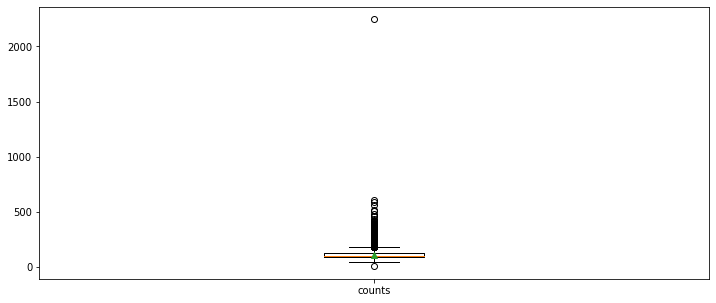

In [40]:
plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot([len_docs],
             labels=['counts'],
             showmeans=True)

{'boxes': [<matplotlib.lines.Line2D at 0x7feb62ed29d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7feb62ed6a50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7feb62eddfd0>],
 'means': [<matplotlib.lines.Line2D at 0x7feb62edda90>],
 'medians': [<matplotlib.lines.Line2D at 0x7feb62edd550>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7feb62ed2f90>,
  <matplotlib.lines.Line2D at 0x7feb62ed6510>]}

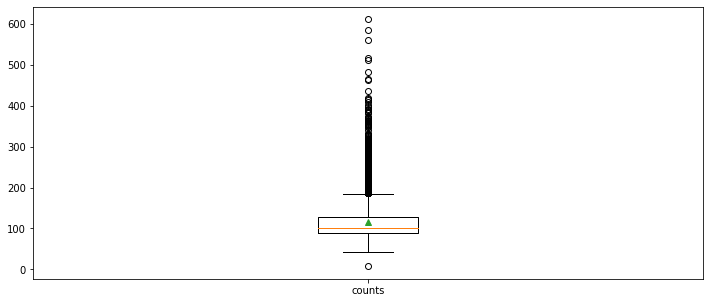

In [42]:
filtered_len_docs = [l for l in len_docs if l < 2000]

plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot(filtered_len_docs,
             labels=['counts'],
             showmeans=True)

Text(0, 0.5, 'Probability')

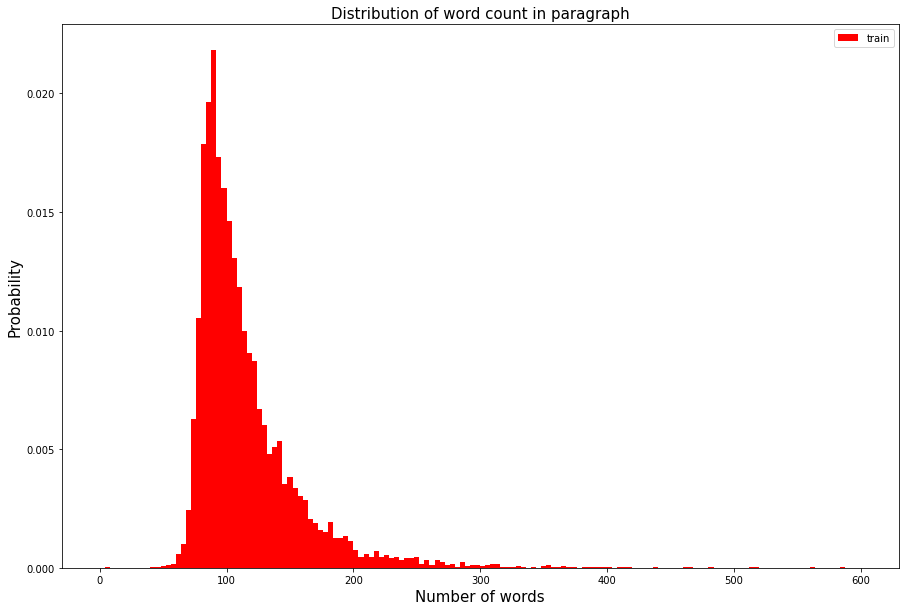

In [43]:
plt.figure(figsize=(15, 10))
plt.hist(filtered_len_docs, bins=150, range=[0,600], facecolor='r', density=True, label='train')
plt.title("Distribution of word count in paragraph", fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

## 지문 텍스트 버트 토크나이저 토큰 길이 분석

In [46]:
len_bert_tokenized_docs = []
for d in documents:
    len_bert_tokenized_docs.append(len(bert_tokenizer.encode(d, add_special_tokens=False).tokens))
    
print('텍스트 최대 길이: {}'.format(np.max(len_bert_tokenized_docs)))
print('텍스트 최소 길이: {}'.format(np.min(len_bert_tokenized_docs)))
print('텍스트 평균 길이: {:.2f}'.format(np.mean(len_bert_tokenized_docs)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(len_bert_tokenized_docs)))
print('텍스트 중간 길이: {}'.format(np.median(len_bert_tokenized_docs)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 텍스트 길이: {}'.format(np.percentile(len_bert_tokenized_docs, 25)))
print('제 3 사분위 텍스트 길이: {}'.format(np.percentile(len_bert_tokenized_docs, 75)))

AttributeError: ignored

## 데이터 전처리

In [52]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=01141e051d719ba16ca8f6b108984dcf3c046f59470a759fa55e521b9f250993
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [53]:
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import urllib
import wget

In [54]:
MAX_LEN = 384
EPOCHS = 3
VERBOSE = 2
BATCH_SIZE = 16

In [55]:
DATA_OUT_PATH = '/content/drive/MyDrive/NLP Model'

In [56]:
def plot_Graphs(history, string, string_1,string_2):
  #loss

  plt.plot(history.history[string])
  plt.plot(history.history[string_1])
  plt.plot

In [57]:
def plot_graphs(history, string, string_1, string_2):
    # loss 
    plt.plot(history.history[string])
    plt.plot(history.history[string_1])
    plt.plot(history.history[string_2])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, string_1, string_2])
    plt.show()

In [58]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)

In [59]:
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", lowercase=False) #기존과 다른 방식으로 토크나이저 사용

save_path = "bert-base-multilingual-cased/" #디렉토리를 만들어서 그곳에 토크나이저 어휘를 담는다.
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path) #자동으로 추가하는 토큰 및 특수 토큰은 추가 X


('bert-base-multilingual-cased/tokenizer_config.json',
 'bert-base-multilingual-cased/special_tokens_map.json',
 'bert-base-multilingual-cased/vocab.txt',
 'bert-base-multilingual-cased/added_tokens.json')

In [60]:
#훈련과 평가를 위한 데이터 불러오기

train_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_train.json"
train_path = keras.utils.get_file("train.json", train_data_url)
eval_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json"
eval_path = keras.utils.get_file("eval.json", eval_data_url)

In [61]:
wget.download('https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json', out='./bert-base-multilingual-cased/')

'./bert-base-multilingual-cased//bert-base-multilingual-cased-config.json'

In [ ]:
os.rename('./bert-base-multilingual-cased/bert-base-multilingual-cased-config.json', './bert-base-multilingual-cased/config.json')


In [62]:
os.rename('./bert-base-multilingual-cased/bert-base-multilingual-cased-config.json', './bert-base-multilingual-cased/config.json')


In [63]:
wget.download('https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-tf_model.h5', out='./bert-base-multilingual-cased/')


'./bert-base-multilingual-cased//bert-base-multilingual-cased-tf_model.h5'

In [64]:
os.rename('./bert-base-multilingual-cased/bert-base-multilingual-cased-tf_model.h5', './bert-base-multilingual-cased/tf_model.h5')


In [70]:
class SquadExample:
    def __init__(self, question, context, start_char_idx, answer_text):
        self.question = question
        self.context = context
        self.start_char_idx = start_char_idx
        self.answer_text = answer_text
        self.skip = False

    def preprocess(self):
        context = self.context
        question = self.question
        answer_text = self.answer_text
        start_char_idx = self.start_char_idx

        # Clean context, answer and question
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())
        answer = " ".join(str(answer_text).split())

        # Find end character index of answer in context
        end_char_idx = start_char_idx + len(answer) #본문의 길이를 넘어가게 되면 답이 본문 범위에 없다는 것을 의미하기에 skip
        if end_char_idx >= len(context):
            self.skip = True
            return

        # Mark the character indexes in context that are in answer
        is_char_in_ans = [0] * len(context)
        for idx in range(start_char_idx, end_char_idx):
            is_char_in_ans[idx] = 1

        # Tokenize context
        tokenized_context = tokenizer.encode(context)

        # Find tokens that were created from answer characters
        ans_token_idx = []
        for idx, (start, end) in enumerate(tokenized_context.offsets):
            if sum(is_char_in_ans[start:end]) > 0:
                ans_token_idx.append(idx)

        if len(ans_token_idx) == 0:
            self.skip = True
            return

        # Find start and end token index for tokens from answer
        #토크나이저 되고 바뀐 정답 시작 인덱스와 끝 인덱스를 변수에 저장
        start_token_idx = ans_token_idx[0]
        end_token_idx = ans_token_idx[-1]

        # Tokenize question
        tokenized_question = tokenizer.encode(question)

        # Create inputs
        input_ids = tokenized_context.ids + tokenized_question.ids[1:]
        token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(
            tokenized_question.ids[1:]
        )
        attention_mask = [1] * len(input_ids)

        # Pad and create attention masks.
        # Skip if truncation is needed
        padding_length = MAX_LEN - len(input_ids) 
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:  # skip 
        # 최대 길이랑 인덱스화된 input 값의 차가 음수이면 데이터 skip
            self.skip = True
            return

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_token_idx = start_token_idx
        self.end_token_idx = end_token_idx
        self.context_token_to_char = tokenized_context.offsets #(위치 인덱스와 음절의 위치)


def create_squad_examples(raw_data):
    squad_examples = []
    for item in raw_data["data"]:
        for para in item["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                question = qa["question"]
                answer_text = qa["answers"][0]["text"]
                start_char_idx = qa["answers"][0]["answer_start"]
                squad_eg = SquadExample(
                    question, context, start_char_idx, answer_text
                )
                squad_eg.preprocess()
                squad_examples.append(squad_eg)
    return squad_examples


def create_inputs_targets(squad_examples):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    return x, y

In [69]:
listlist = ['lion','tiger','hero']
listlist[-1]

'hero'

In [ ]:
class SquadExample:
    def __init__(self, question, context, start_char_idx, answer_text):
        self.question = question
        self.context = context
        self.start_char_idx = start_char_idx
        self.answer_text = answer_text
        self.skip = False

    def preprocess(self):
        context = self.context
        question = self.question
        answer_text = self.answer_text
        start_char_idx = self.start_char_idx

        # Clean context, answer and question
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())
        answer = " ".join(str(answer_text).split())

        # Find end character index of answer in context
        end_char_idx = start_char_idx + len(answer)
        if end_char_idx >= len(context):
            self.skip = True
            return

        # Mark the character indexes in context that are in answer
        is_char_in_ans = [0] * len(context)
        for idx in range(start_char_idx, end_char_idx):
            is_char_in_ans[idx] = 1

        # Tokenize context
        tokenized_context = tokenizer.encode(context)

        # Find tokens that were created from answer characters
        ans_token_idx = []
        for idx, (start, end) in enumerate(tokenized_context.offsets):
            if sum(is_char_in_ans[start:end]) > 0:
                ans_token_idx.append(idx)

        if len(ans_token_idx) == 0:
            self.skip = True
            return

        # Find start and end token index for tokens from answer
        start_token_idx = ans_token_idx[0]
        end_token_idx = ans_token_idx[-1]

        # Tokenize question
        tokenized_question = tokenizer.encode(question)

        # Create inputs
        input_ids = tokenized_context.ids + tokenized_question.ids[1:]
        token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(
            tokenized_question.ids[1:]
        )
        attention_mask = [1] * len(input_ids)

        # Pad and create attention masks.
        # Skip if truncation is needed
        padding_length = MAX_LEN - len(input_ids)
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:  # skip
            self.skip = True
            return

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_token_idx = start_token_idx
        self.end_token_idx = end_token_idx
        self.context_token_to_char = tokenized_context.offsets


def create_squad_examples(raw_data):
    squad_examples = []
    for item in raw_data["data"]:
        for para in item["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                question = qa["question"]
                answer_text = qa["answers"][0]["text"]
                start_char_idx = qa["answers"][0]["answer_start"]
                squad_eg = SquadExample(
                    question, context, start_char_idx, answer_text
                )
                squad_eg.preprocess()
                squad_examples.append(squad_eg)
    return squad_examples


def create_inputs_targets(squad_examples):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    return x, y

In [ ]:
class TFBERTQuestionAnswering(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBERTQuestionAnswering, self).__init__()
        
        self.encoder = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.start_logit = tf.keras.layers.Dense(num_class, name="start_logit", use_bias=False)
        self.end_logit = tf.keras.layers.Dense(num_class, name="end_logit", use_bias=False)
        self.flatten = tf.keras.layers.Flatten() 
        self.softmax = tf.keras.layers.Activation(tf.keras.activations.softmax)
        
    def call(self, inputs):
        input_ids, token_type_ids, attention_mask = inputs
        embedding = self.encoder(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
        start_logits = self.start_logit(embedding)
        start_logits = self.flatten(start_logits)
        
        end_logits = self.end_logit(embedding)
        end_logits = self.flatten(end_logits)
        
        start_probs = self.softmax(start_logits)
        end_probs = self.softmax(end_logits)
    
        return start_probs, end_probs

In [ ]:
korquad_model = TFBERTQuestionAnswering(model_name='./bert-base-multilingual-cased/',dir_path='bert_ckpt', num_class=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [ ]:
#한국어가 아닌 특수문자가 성능에 영향을 줄 수 있어서 아래 함수를 적용

def normalized_answer(s):    
    def remove_(text):
        ''' 불필요한 기호 제거 '''
        text = re.sub("'", " ", text)
        text = re.sub('"', " ", text)
        text = re.sub('《', " ", text)
        text = re.sub('》', " ", text)
        text = re.sub('<', " ", text)
        text = re.sub('>', " ", text) 
        text = re.sub('〈', " ", text)
        text = re.sub('〉', " ", text)   
        text = re.sub("\(", " ", text)
        text = re.sub("\)", " ", text)
        text = re.sub("‘", " ", text)
        text = re.sub("’", " ", text)      
        return text

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_punc(lower(remove_(s))))

In [ ]:
class ExactMatch(keras.callbacks.Callback):
    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def on_epoch_end(self, epoch, logs=None):
        pred_start, pred_end = self.model.predict(self.x_eval)
        count = 0
        eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False]
        for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
            squad_eg = eval_examples_no_skip[idx]
            offsets = squad_eg.context_token_to_char
            start = np.argmax(start)
            end = np.argmax(end)
            if start >= len(offsets):
                continue
            pred_char_start = offsets[start][0]
            if end < len(offsets):
                pred_char_end = offsets[end][1]
                pred_ans = squad_eg.context[pred_char_start:pred_char_end]
            else:
                pred_ans = squad_eg.context[pred_char_start:]

            normalized_pred_ans = normalized_answer(pred_ans)
            normalized_true_ans = normalized_answer(squad_eg.answer_text)
            if normalized_pred_ans in normalized_true_ans:
                count += 1
        acc = count / len(self.y_eval[0])
        print(f"\nepoch={epoch+1}, exact match score={acc:.2f}")

In [ ]:
exact_match_callback = ExactMatch(x_eval, y_eval)

In [ ]:
korquad_model.compile(optimizer=optimizer, loss=[loss, loss])

In [ ]:
model_name = "tf2_bert_korquad"

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)

In [ ]:
history = korquad_model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,  # For demonstration, 3 epochs are recommended
    verbose=VERBOSE,
    batch_size=BATCH_SIZE,
    callbacks=[exact_match_callback, cp_callback]
)

In [ ]:
print(history.history)

In [ ]:
plot_graphs(history, 'loss', 'output_1_loss', 'output_2_loss')